# Exploratory analysis of the iNaturalist (2021) dataset

In [2]:
import json
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
!wget "https://ml-inat-competition-datasets.s3.amazonaws.com/2021/train.json.tar.gz"
!wget "https://ml-inat-competition-datasets.s3.amazonaws.com/2021/val.json.tar.gz"

--2024-06-28 14:05:22--  https://ml-inat-competition-datasets.s3.amazonaws.com/2021/train.json.tar.gz
Resolving ml-inat-competition-datasets.s3.amazonaws.com (ml-inat-competition-datasets.s3.amazonaws.com)... 52.219.107.68, 52.219.142.52, 52.219.92.84, ...
Connecting to ml-inat-competition-datasets.s3.amazonaws.com (ml-inat-competition-datasets.s3.amazonaws.com)|52.219.107.68|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 230885383 (220M) [application/gzip]
Saving to: ‘train.json.tar.gz.1’

train.json.tar.gz.1 100%[===================>] 220.19M  15.9MB/s    in 12s     

2024-06-28 14:05:34 (19.0 MB/s) - ‘train.json.tar.gz.1’ saved [230885383/230885383]

--2024-06-28 14:05:34--  https://ml-inat-competition-datasets.s3.amazonaws.com/2021/val.json.tar.gz
Resolving ml-inat-competition-datasets.s3.amazonaws.com (ml-inat-competition-datasets.s3.amazonaws.com)... 52.219.100.243, 52.219.141.36, 52.219.178.124, ...
Connecting to ml-inat-competition-datasets.s3.amazona

In [4]:
# unzip metadata
!tar -xzf train.json.tar.gz
!tar -xzf val.json.tar.gz

In [5]:
# load in train set metadata
with open("train.json", "r") as json_file:
  train_metadata_dict = json.load(json_file)

# load in val set metadata
with open("val.json", "r") as json_file:
  val_metadata_dict = json.load(json_file)

In [6]:
print(train_metadata_dict.keys())

dict_keys(['info', 'images', 'categories', 'annotations', 'licenses'])


In [7]:
category_metadata = train_metadata_dict['categories']

In [8]:
# possible supercategories
supercategories = {item.get('supercategory') for item in category_metadata}
print(supercategories)

{'Amphibians', 'Arachnids', 'Birds', 'Fungi', 'Plants', 'Ray-finned Fishes', 'Animalia', 'Mammals', 'Mollusks', 'Insects', 'Reptiles'}


In [18]:
category_metadata[0]

{'id': 0,
 'name': 'Lumbricus terrestris',
 'common_name': 'Common Earthworm',
 'supercategory': 'Animalia',
 'kingdom': 'Animalia',
 'phylum': 'Annelida',
 'class': 'Clitellata',
 'order': 'Haplotaxida',
 'family': 'Lumbricidae',
 'genus': 'Lumbricus',
 'specific_epithet': 'terrestris',
 'image_dir_name': '00000_Animalia_Annelida_Clitellata_Haplotaxida_Lumbricidae_Lumbricus_terrestris'}

In [9]:
# Get number of plant species
plant_species_metadata = {category['id']: category for category in category_metadata if category['supercategory'] == 'Plants'}
print(f"Number of plant species = {len(plant_species_metadata)}")

Number of plant species = 4271


# 1. Investigate which Toolbox of multispecies sward (toms) plants are in iNaturalist dataset

In [25]:
# First lookup TOMS (https://www.multispeciessward.co.uk/) species in the dataset

toms_species_latin = [
    'Trifolium pratense',
    'Trifolium repens',
    'Trifolium hybridum',
    'Medicago sativa',
    'Onobrychis viciifolia',
    'Lotus corniculatus',
    'Cichorium intybus',
    'Plantago lanceolata',
    'Achillea millefolium',
    'Sanguisorba minor',
    'Petroselinum crispum',
    'Lolium perenne',
    'Dactylis glyomerata',
    'Phleum pratense',
    'Schedonorus arundinaceus',
    'Schedonorus pratensis',
    'Alopecurus pratensis',
]

print(len(toms_species_latin))

17


In [59]:
# check presence using direct string matching (latin)
iNaturalist_names = [metadata['name'] for cat_id, metadata in plant_species_metadata.items()]
toms_iNaturalist_species_names = [(toms_name, iNat_name) for toms_name in toms_species_latin for iNat_name in iNaturalist_names if toms_name in iNat_name]
print(toms_iNaturalist_species_names)
print(f"Number of toms species in iNaturalist = {len(toms_iNaturalist_species_names)}/17")

[('Trifolium pratense', 'Trifolium pratense'), ('Trifolium repens', 'Trifolium repens'), ('Trifolium hybridum', 'Trifolium hybridum'), ('Medicago sativa', 'Medicago sativa'), ('Onobrychis viciifolia', 'Onobrychis viciifolia'), ('Lotus corniculatus', 'Lotus corniculatus'), ('Cichorium intybus', 'Cichorium intybus'), ('Plantago lanceolata', 'Plantago lanceolata'), ('Achillea millefolium', 'Achillea millefolium'), ('Sanguisorba minor', 'Sanguisorba minor'), ('Lolium perenne', 'Lolium perenne'), ('Phleum pratense', 'Phleum pratense'), ('Alopecurus pratensis', 'Alopecurus pratensis')]
Number of toms species in iNaturalist = 13/17


# 2. Assemble metadata

In [10]:
# Combine image metadata of test and val sets
train_val_annotation_metadata = train_metadata_dict['annotations'] + val_metadata_dict['annotations']

print(f"tot images (train + val) = {len(train_val_annotation_metadata)}")

tot images (train + val) = 2786843


In [11]:
# Make dict for mapping
image_to_category = {annotation['image_id']: annotation['category_id'] for annotation in train_val_annotation_metadata if annotation['category_id'] in plant_species_metadata.keys()}
print(f"Number of plant images: {len(image_to_category)}")

Number of plant images: 1191412


In [14]:
# Make dict of plant images species metadata
plant_image_metadata = {}
for image_id, category_id in image_to_category.items():
  image_species_metadata = plant_species_metadata[category_id]
  image_species_metadata_updated = {'category_id' if k == 'id' else k: v for k, v in image_species_metadata.items()}
  image_species_metadata_updated['image_id'] = image_id
  plant_image_metadata[image_id] = image_species_metadata_updated

In [16]:
# Make df of plant images metadata

metadata_df = pd.DataFrame.from_dict(plant_image_metadata, orient='index')

metadata_df.head()

,category_id,name,common_name,supercategory,kingdom,phylum,class,order,family,genus,specific_epithet,image_dir_name,image_id
7,5804,Peltandra virginica,Green Arrow Arum,Plants,Plantae,Tracheophyta,Liliopsida,Alismatales,Araceae,Peltandra,virginica,05804_Plantae_Tracheophyta_Liliopsida_Alismata...,7
18,6745,Dittrichia graveolens,Stinkwort,Plants,Plantae,Tracheophyta,Magnoliopsida,Asterales,Asteraceae,Dittrichia,graveolens,06745_Plantae_Tracheophyta_Magnoliopsida_Aster...,18
19,6172,Lilium humboldtii,Humboldt's Lily,Plants,Plantae,Tracheophyta,Liliopsida,Liliales,Liliaceae,Lilium,humboldtii,06172_Plantae_Tracheophyta_Liliopsida_Liliales...,19
20,9244,Delphinium parishii,desert larkspur,Plants,Plantae,Tracheophyta,Magnoliopsida,Ranunculales,Ranunculaceae,Delphinium,parishii,09244_Plantae_Tracheophyta_Magnoliopsida_Ranun...,20
21,9239,Delphinium cardinale,Scarlet Larkspur,Plants,Plantae,Tracheophyta,Magnoliopsida,Ranunculales,Ranunculaceae,Delphinium,cardinale,09239_Plantae_Tracheophyta_Magnoliopsida_Ranun...,21


# 2. Explore class (species) distribution

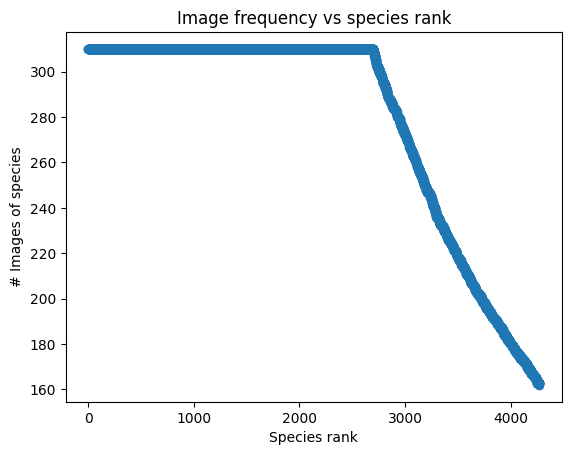

In [26]:
# plot species frequency vs rank (shows zipf's law behaviour)

species_counts = metadata_df['name'].value_counts()

species_ranks = range(1, len(species_counts) + 1)

fig, ax = plt.subplots()

ax.scatter(species_ranks, species_counts[species_counts.index])
ax.set_xlabel("Species rank")
ax.set_ylabel("# Images of species")
ax.set_title("Image frequency vs species rank")

plt.show()

Number of images of toms species = 4030


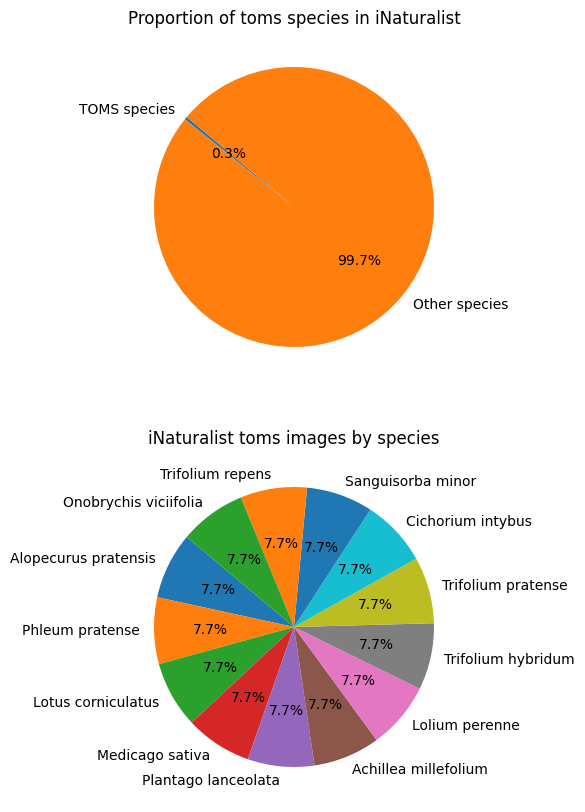

In [58]:
# Proportion of plant images that are toms species

toms_names = {metadata['name'] for image_id, metadata in plant_image_metadata.items() if metadata['name'] in toms_species_latin}

fig, axs = plt.subplots(2, 1, figsize = (20, 10))

toms_species_metadata = metadata_df[metadata_df['name'].isin(toms_names)]
print(f"Number of images of toms species = {len(toms_species_metadata)}")

pct_toms_species = (len(toms_species_metadata) / len(metadata_df)) * 100
pct_other_species = 100 - pct_toms_species

overall_labels = ['TOMS species', 'Other species']
toms_proportion = [pct_toms_species, pct_other_species]

axs[0].pie(toms_proportion, labels=overall_labels, autopct='%1.1f%%', startangle=140)
axs[0].set_title("Proportion of toms species in iNaturalist")

toms_species_counts = toms_species_metadata['name'].value_counts()
toms_species_labels = [str(cat_id) for cat_id in toms_species_counts.index]
toms_species_proportions = toms_species_counts.values

axs[1].pie(toms_species_proportions, labels=toms_species_labels, autopct='%1.1f%%', startangle=140)
axs[1].set_title("iNaturalist toms images by species")

plt.show()

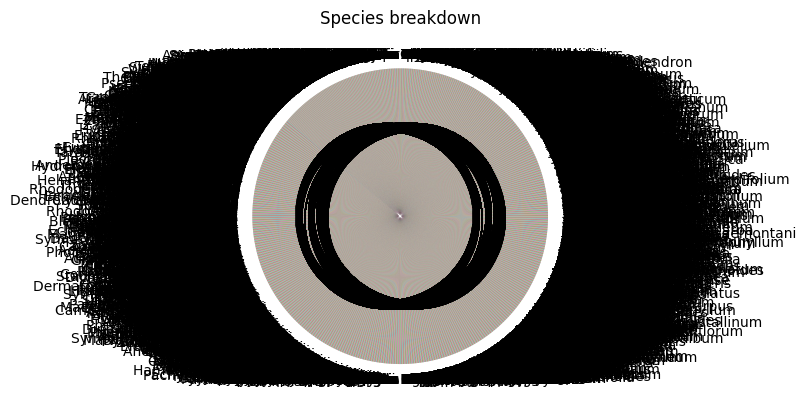

In [60]:
# Image distribution by species

species_counts = metadata_df['name'].value_counts()

fig, ax = plt.subplots()
ax.pie(species_counts, labels=species_counts.index, autopct='%1.1f%%', startangle=140)
ax.set_title('Species breakdown')

plt.show()


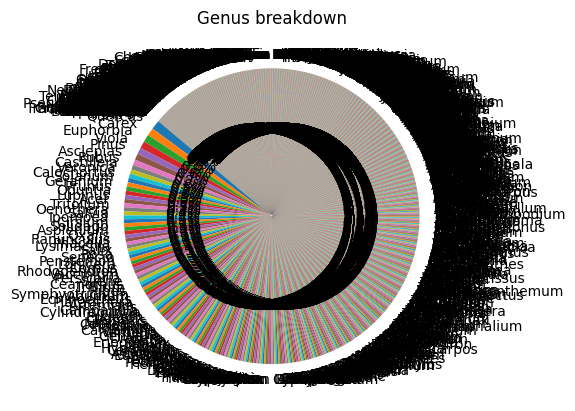

In [65]:
# Image distribution by species

genus_counts = metadata_df['genus'].value_counts()

fig, ax = plt.subplots()
ax.pie(genus_counts, labels=genus_counts.index, autopct='%1.1f%%', startangle=140)
ax.set_title('Genus breakdown')

plt.show()


In [64]:
# Report list of frequent genus

genus_counts = metadata_df['genus'].value_counts()

print("Twenty most frequent genuses:\n")
for i, genus in enumerate(genus_counts[:20]):
  print(f"Genus name: {genus_counts.index[i]}, Num images: {genus_counts.values[i]}")

Twenty most frequent genuses:

Genus name: Quercus, Num images: 12215
Genus name: Carex, Num images: 10017
Genus name: Euphorbia, Num images: 9867
Genus name: Viola, Num images: 9257
Genus name: Pinus, Num images: 8367
Genus name: Asclepias, Num images: 8282
Genus name: Rubus, Num images: 7138
Genus name: Castilleja, Num images: 6103
Genus name: Veronica, Num images: 5812
Genus name: Calochortus, Num images: 5721
Genus name: Solanum, Num images: 5542
Genus name: Geranium, Num images: 5530
Genus name: Prunus, Num images: 5481
Genus name: Opuntia, Num images: 5444
Genus name: Lupinus, Num images: 5412
Genus name: Acer, Num images: 5375
Genus name: Trifolium, Num images: 5307
Genus name: Oenothera, Num images: 5280
Genus name: Salvia, Num images: 5174
Genus name: Ipomoea, Num images: 5099
